<h1 style="text-align: center; font-size:2.5em; color:#7CA280"> Assignment 2 </h1>

# <u style="color:#7CA280"> Part 1: Twitter Network Analysis</u>

### <i style="color:#7CA280"> Exercise 1: Build the network of retweets.</i>

We will now build a network that has as nodes the Twitter handles of the members of the house, and direct edges between nodes A and B if A has retweeted content posted by B. We will build a weighted network, where the weight of an edge is equal to the number of retweets.

In [3]:
import networkx as nx
import pandas as pd
import os
import re
import io

- First, we go through all the files (provided in the Repository of the course) and add a node per congressman.

In [7]:
path = 'data/tweets/'

#Directed graph
rt_graph = nx.DiGraph()

#Undirected graph.
#Useful in future exercises
rt_nonDirgraph = nx.Graph()

#Relation Twitter profile to Party
tw_parties = pd.read_csv('./data/H115_tw.csv')

for file in os.listdir(path):
    # Include the member we are analysing to the network
    rt_graph.add_node(file,
                      party = tw_parties[tw_parties.tw_name == file].Party,
                      betrayals = 0 #rt to other party
                     )
    #Include nodes in non directed graph for future exercises
    rt_nonDirgraph.add_node(file,
                      party = tw_parties[tw_parties.tw_name == file].Party,
                      betrayals = 0)

- Using the nodes in the network we just created, we look for the retweets each of them has performed using a regular expression.
- Once all retweets are located, we add the corresponding edges in the network.

In [12]:
for acc in rt_graph.nodes:
    f = io.open(path+acc, 'r', encoding='utf-8').read()
    
    #We find all his RTs
    rts = re.findall(r"(RT)((?:\b\W@(\w+))+)", f)
    
    for rt in rts:
        original = rt[2] #we only get the user name
        if original in rt_graph.nodes: #if it is a member
            #check if edge already exists
            if rt_graph.has_edge(acc, original):
                rt_graph[acc][original]['weight'] += 1
            else:
                rt_graph.add_edge(acc,
                                  original,
                                  weight=1)

# removing self loops
rt_graph.remove_edges_from(rt_graph.selfloop_edges())

<hr>

### <i style="color:#7CA280"> Exercise 2: Visualize the network of retweets and investigate differences between the parties. </i>

- Using the Networkx draw function and the force atlas algorithm, we can plot the network we built in the previous exercise.

In [13]:
# Need to create de non-directed graph.
# Nodes are already in the network, only need to create the edges.
for acc in rt_nonDirgraph.nodes:
    
    f = io.open(path+acc, 'r', encoding='utf-8').read()
    
    #We find all his RTs
    rts = re.findall(r"(RT)((?:\b\W@(\w+))+)", f)
    
    for rt in rts:
        #we only get the user name
        poster = rt[2]
        if poster in rt_nonDirgraph.nodes: #if it is a member
            #check if edge already exists
            if rt_nonDirgraph.has_edge(acc, poster):
                rt_nonDirgraph[acc][poster]['weight'] += 1
                #print(rt_graph[acc][poster]['weight'])
            else:
                #new edge created
                rt_nonDirgraph.add_edge(acc,
                                  poster,
                                  weight=1)

100%|██████████| 8000/8000 [00:15<00:00, 518.70it/s]


BarnesHut Approximation  took  4.16  seconds
Repulsion forces  took  9.79  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.12  seconds
AdjustSpeedAndApplyForces step  took  0.65  seconds


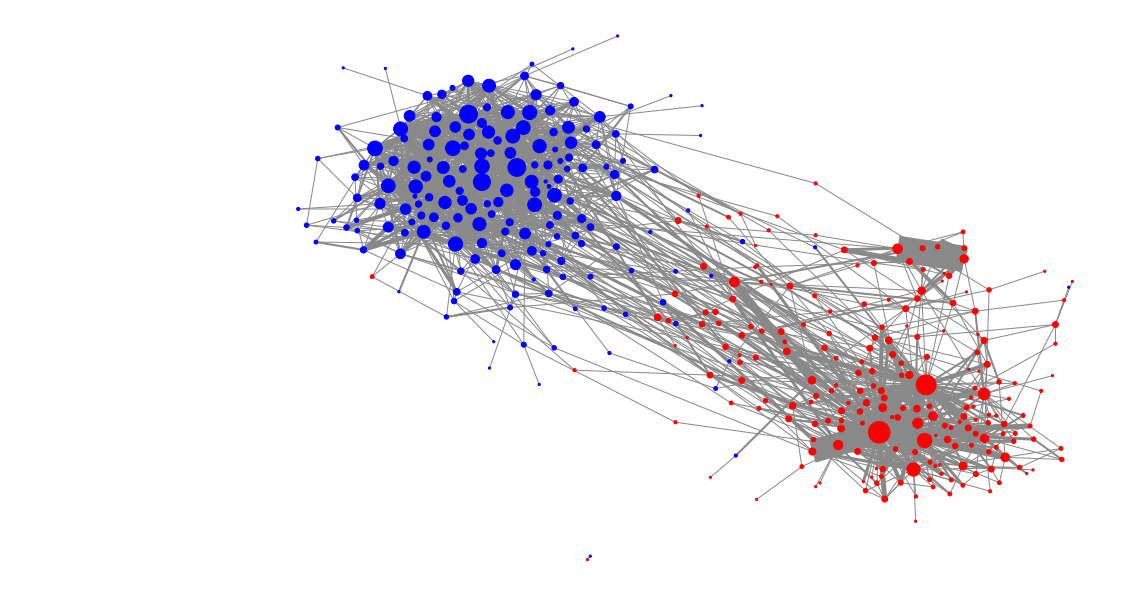

In [14]:
import fa2
import matplotlib.pyplot as plt

forceatlas2 = fa2.ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=0,

    # Performance
    jitterTolerance=.01,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    scalingRatio= 1,
    strongGravityMode=True,
    gravity=200,
    # Log
    verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(rt_nonDirgraph,
                                                    pos=None,
                                                    iterations=8000);

#We use this list to ease the coloring of nodes
node_colors = []
for node in rt_nonDirgraph:
    if rt_nonDirgraph.node[node]['party'].item() == 'Republican':
        node_colors.append("red")
    else:
        node_colors.append("blue")

# creating a dic containing all nodes degree
degrees = {}
for node, degree in nx.degree(rt_graph):
    degrees[node] = degree

# creating a dic containing all edges weight
weights = {}
for u, v in rt_nonDirgraph.edges:
    weights[(u, v)] = rt_nonDirgraph[u][v]['weight']
    
plt.rcParams["figure.figsize"] = [15, 8];  
nx.draw(rt_nonDirgraph,
        positions,
        cmap=plt.get_cmap('jet'),
        edge_color="#898989",
        #nodelist=degrees.keys(),
        node_size=[v * 5 for v in degrees.values()],
        node_color = node_colors,
        overlap = False,
        width = [w for w in weights.values()],
        with_labels=False)

- Compare the network of Retweets with the network of Wikipedia pages (Week 5, exercise 2). Do you observe any difference? How do you explain them?
    - _There are two main differences we find in this network compared to the one using Wikipedia:_
        - _Firstly, some of the nodes are not connected to others. This can be because they never retweeted any content of because their content was retweeted but they are not members of the congress._
        - _Secondly, there as a much clear association of the nodes within their parties. We can see that most of the nodes are connected to members of the same party._

- Now set the nodes' size proportional to their betweenness centrality. What do you observe?
    - _We observe an uneven distribution of centrality._

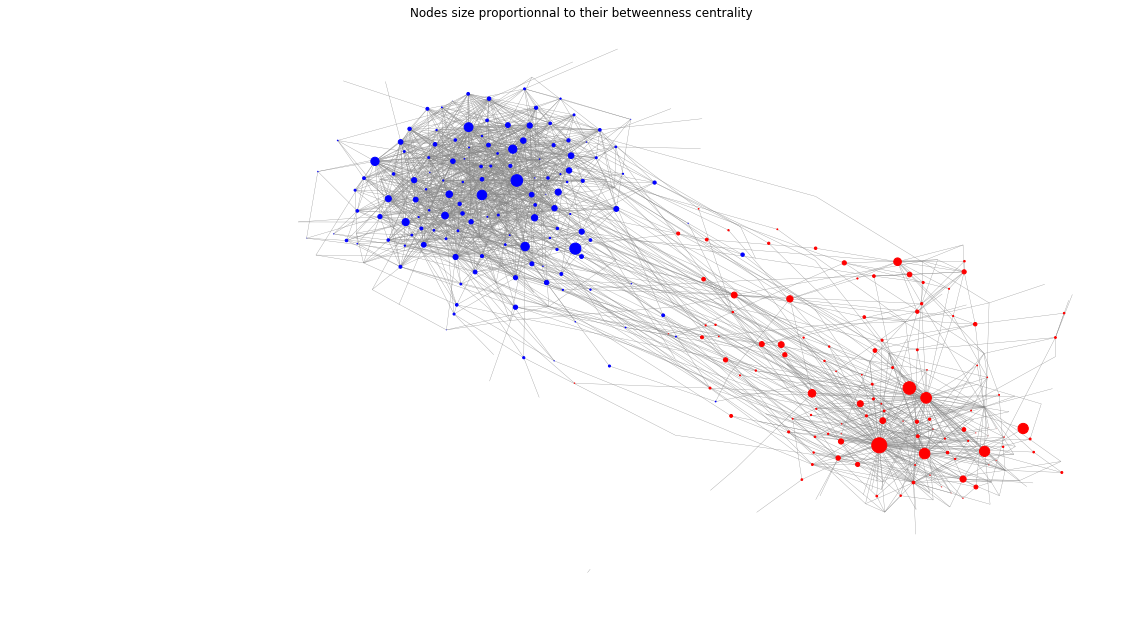

In [15]:
plt.rcParams["figure.figsize"] = [15, 8];

weights = {}
for u, v in rt_nonDirgraph.edges:
    weights[(u, v)] = rt_nonDirgraph[u][v]['weight']
    
nx.draw(rt_nonDirgraph,
        positions,
        cmap=plt.get_cmap('jet'),
        #nodelist=degrees.keys(),
        node_size = [v * 2000 for v in nx.betweenness_centrality(rt_graph).values()],
        node_color = node_colors,
        edge_color="#898989",
        overlap = False,
        width = .3, # using fixed width for displaying convenience
        with_labels=False)

plt.title("Nodes size proportionnal to their betweenness centrality");

- Repeat the point above using eigenvector centrality instead. Is there any difference? Can you explain why?
    - _We can see in the graph below that republicans tend to have thiner nodes thant democrates. Since the eigenvector centrality tends to measure the influence of a node in a network we can guess that republicans are less influent than democrates._

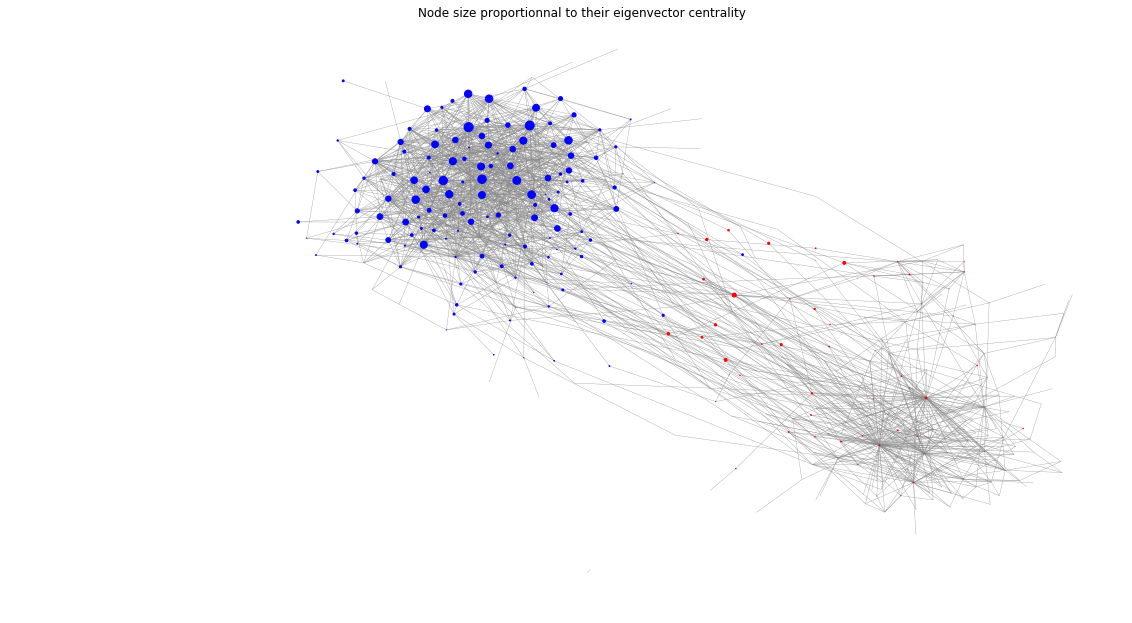

In [16]:
plt.rcParams["figure.figsize"] = [15, 8];

nx.draw(rt_nonDirgraph,
        positions,
        cmap=plt.get_cmap('jet'),
        #nodelist=degrees.keys(),
        node_size = [v * 300 for v in nx.eigenvector_centrality(rt_graph).values()],
        node_color = node_colors,
        edge_color="#898989",
        overlap = False,
        width = .3,
        with_labels=False)

plt.title("Node size proportionnal to their eigenvector centrality");

- Who are the three nodes with highest degree within each party? And eigenvector centrality? And betweenness centrality?

    - _We create two lists (one per party) where each of the values inside the lists include a fourplet (node, degree, eigenvector distribution, betweenness distribution)._

In [18]:
rep_deg, dem_deg = [], []

for node in rt_graph.nodes():
    if rt_nonDirgraph.node[node]['party'].item() == 'Republican':
        rep_deg.append((node,
                        rt_graph.degree(node),
                        nx.eigenvector_centrality(rt_graph, 1000)[node],
                        nx.betweenness_centrality(rt_graph)[node]))
    else:
        dem_deg.append((node,
                        rt_graph.degree(node),
                        nx.eigenvector_centrality(rt_graph, 1000)[node],
                        nx.betweenness_centrality(rt_graph)[node]
                      ))

In [19]:
#We sort the congressmen using the second value (indexed as 1) which is its degree.
top3_deg = sorted(rt_graph.degree(), key=lambda x: x[1], reverse = True)[:3]
top3_deg_rep = sorted(rep_deg, key=lambda x: x[1], reverse = True)[:3]
top3_deg_dem = sorted(dem_deg, key=lambda x: x[1], reverse = True)[:3]

In [20]:
print('Three nodes with highest degree:')
for node in top3_deg:
    print('– ', node[0], ": ", node[1])

print('\nThree republicans with highest degree:')
for node in top3_deg_rep:
    print('– ', node[0], ": ", node[1])

print('\nThree democrats with highest degree:')
for node in top3_deg_dem:
    print('– ', node[0], ": ", node[1])

Three nodes with highest degree:
–  SpeakerRyan :  93
–  SteveScalise :  79
–  NancyPelosi :  63

Three republicans with highest degree:
–  SpeakerRyan :  93
–  SteveScalise :  79
–  GOPLeader :  42

Three democrats with highest degree:
–  NancyPelosi :  63
–  repmarkpocan :  63
–  WhipHoyer :  58


In [21]:
# We do the same using the third and fourth values: eigenvector and betweenness distribution
top3_eig_rep = sorted(rep_deg, key=lambda x: x[2], reverse = True)[:3]
top3_eig_dem = sorted(dem_deg, key=lambda x: x[2], reverse = True)[:3]
top3_bet_rep = sorted(rep_deg, key=lambda x: x[3], reverse = True)[:3]
top3_bet_dem = sorted(dem_deg, key=lambda x: x[3], reverse = True)[:3]

In [22]:
print('Three republicans with highest eigenvector centrality:')
for node in top3_eig_rep:
    print('– ', node[0], ": ", node[2])
    
print('\nThree democrats with highest eigenvector centrality:')
for node in top3_eig_dem:
    print('– ', node[0], ": ", node[2])

print('\nThree republicans with highest betweenness centrality:')
for node in top3_bet_rep:
    print('– ', node[0], ": ", node[3])

print('\nThree democrats with highest betweenness centrality:')
for node in top3_bet_dem:
    print('– ', node[0], ": ", node[3])

Three republicans with highest eigenvector centrality:
–  RosLehtinen :  0.05314824347623461
–  RepSteveStivers :  0.02954542032696024
–  justinamash :  0.028403717821331043

Three democrats with highest eigenvector centrality:
–  repmarkpocan :  0.2711250612528277
–  RepBeatty :  0.26512107057771106
–  RepCummings :  0.23799435256020762

Three republicans with highest betweenness centrality:
–  SpeakerRyan :  0.11323246961084296
–  PatrickMcHenry :  0.07927652852223582
–  SteveScalise :  0.05662851413708352

Three democrats with highest betweenness centrality:
–  NancyPelosi :  0.06723386821176298
–  RepDavidEPrice :  0.06169886508856411
–  WhipHoyer :  0.045009931292083034


- Plot on the same figure the distribution of outgoing strength for the republican and democratic nodes (e.g. the sum of the weight on outgoing links). Which party is more active in retweeting other members of the house?
    - _According to the following plot the republicans are more active in retweeing than democrates (almost twice more).

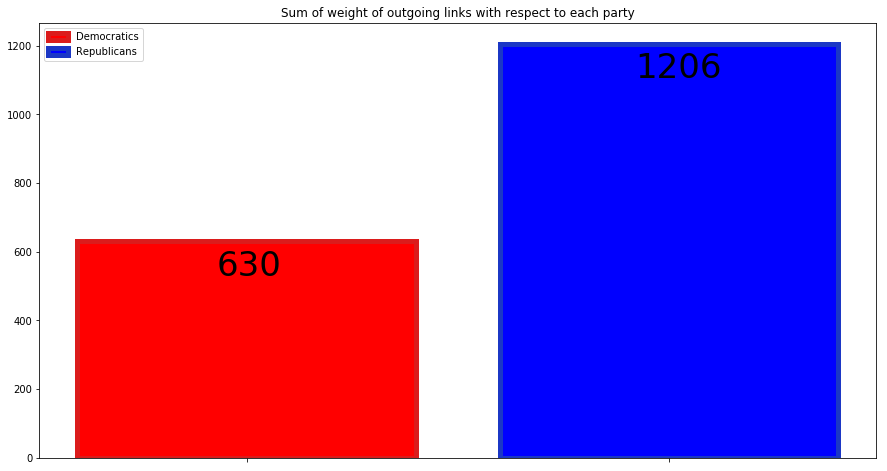

In [23]:
sum_rep, sum_dem = 0, 0

for node in rt_graph.nodes():
    if rt_graph.node[node]['party'].item() == 'Republican':
        sum_rep += rt_graph.out_degree(node)
    else:
        sum_dem += rt_graph.out_degree(node)

b = plt.bar([1,2],[sum_rep, sum_dem], color=["red","blue"], edgecolor=["#DB1C1C","#1B37C5"], linewidth=5);
plt.text(b[0].get_width()+0.13,b[0].get_height()-100 ,str(b[0].get_height()), fontsize=34)
plt.text(b[1].get_width()+1.12,b[1].get_height()-100 ,str(b[1].get_height()), fontsize=34)
a = plt.xticks([1,2], ('',''));
a = plt.legend((b[0],b[1]),('Democratics', 'Republicans'));
plt.title("Sum of weight of outgoing links with respect to each party");

- Find the 3 members of the republican party that have retweet more often tweets from democratic members. Repeat the measure for the democratic members. Can you explain your results by looking at the Wikipedia pages of these members of the house?

In [24]:
for edge in rt_graph.edges:

    acc = edge[0]
    poster = edge[1]

    if rt_graph.nodes[acc]['party'].item() != rt_graph.nodes[poster]['party'].item():
        rt_graph.nodes[acc]['betrayals'] += 1

In [25]:
betrayers_rep = []
betrayers_dem = []
for node in rt_graph.nodes:
    if rt_graph.nodes[node]['party'].item() == 'Republican':
        betrayers_rep.append((node, rt_graph.nodes[node]['betrayals']))
    else:
        betrayers_dem.append((node, rt_graph.nodes[node]['betrayals']))

In [26]:
top3_betrayers_rep = sorted(betrayers_rep, key=lambda x: x[1], reverse = True)[:3]
top3_betrayers_dem = sorted(betrayers_dem, key=lambda x: x[1], reverse = True)[:3]
print('Top3 republicans who retweeted democrats:')
for node in top3_betrayers_rep:
    print('– ', node[0], ': ', node[1])
print('\nTop3 democrats who retweeted republicans:')
for node in top3_betrayers_dem:
    print('– ', node[0], ': ', node[1])

Top3 republicans who retweeted democrats:
–  RepRyanCostello :  5
–  RepMikeTurner :  4
–  TomRooney :  3

Top3 democrats who retweeted republicans:
–  RepDebDingell :  3
–  RepAnnaEshoo :  2
–  RepCartwright :  2


<hr>

### <i style="color:#7CA280"> Exercise 3: Community detection.</i>

- Use your favorite method of community detection to find communities in the full house of representatives network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found for the Wikipedia network? Comment on your result.

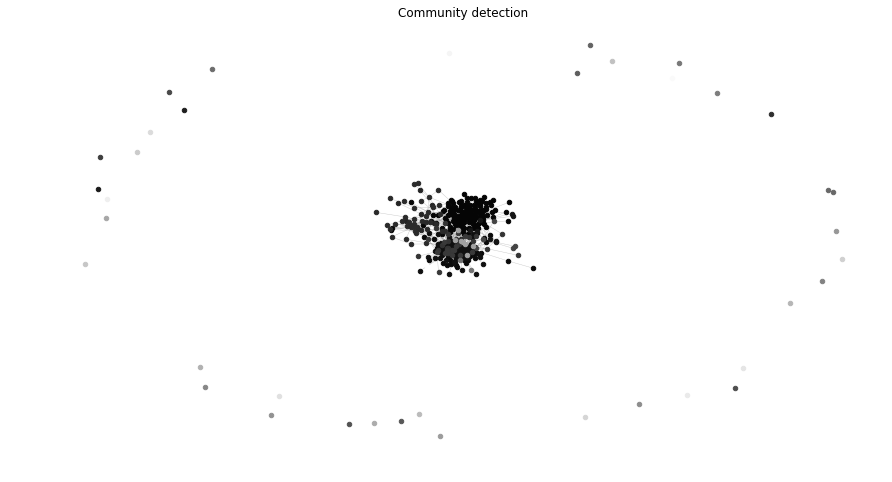

In [27]:
import community
import matplotlib.pyplot as plt

partition = community.best_partition(rt_nonDirgraph)

#drawing
plt.rcParams["figure.figsize"] = [15, 8];
size = float(len(set(partition.values())))
pos = nx.fruchterman_reingold_layout(rt_nonDirgraph)
count = 0.
for com in set(partition.values()):
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                  if partition[nodes] == com]
    nx.draw_networkx_nodes(rt_nonDirgraph,
                          pos,
                          list_nodes,
                          node_size = 20,
                          node_color = str(count/size))
nx.draw_networkx_edges(rt_nonDirgraph, pos, alpha=.5, width=.4, edge_color="#898989")
plt.axis('off')
plt.title("Community detection");

In [28]:
L = len(rt_graph.edges()) #Total amount of edges
L_rep, L_dem = 0, 0

for edge in rt_graph.edges():
    if tw_parties[tw_parties.tw_name == edge[0]].Party.values[0] == tw_parties[tw_parties.tw_name == edge[1]].Party.values[0] == 'Republican':
        L_rep += 1
    elif tw_parties[tw_parties.tw_name == edge[0]].Party.values[0] == tw_parties[tw_parties.tw_name == edge[1]].Party.values[0] == 'Democratic':
        L_dem += 1

K_rep, K_dem = 0, 0
for elt in list(rt_graph.degree()):
    if tw_parties[tw_parties.tw_name == elt[0]].Party.values[0] == 'Republican':
        K_rep += elt[1]
    else:
        K_dem += elt[1]
        
modularity = (L_rep/L - pow(K_rep/(2*L),2)) + (L_dem/L - pow(K_dem/(2*L),2))
print('Modularity = ', modularity)

Modularity =  0.3805350268889932


_We have a positive modularity which means that the number of edges within groups exceeds the number expected on the basis of chance. Furthermore, since it is bigger than 0.3 we can assume that the clustering is relevant._

- Visualize the network, using the Force Atlas algorithm (see Lecture 5, exercise 2). This time assign each node a different color based on their community. Describe the structure you observe.
    - _On the following network each node color represents a community. We can observe three main ones (which are cyan, white and black) and that nodes inside thoses communities tends to link together._

100%|██████████| 6000/6000 [00:15<00:00, 391.98it/s]


BarnesHut Approximation  took  3.30  seconds
Repulsion forces  took  10.87  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.06  seconds
AdjustSpeedAndApplyForces step  took  0.50  seconds


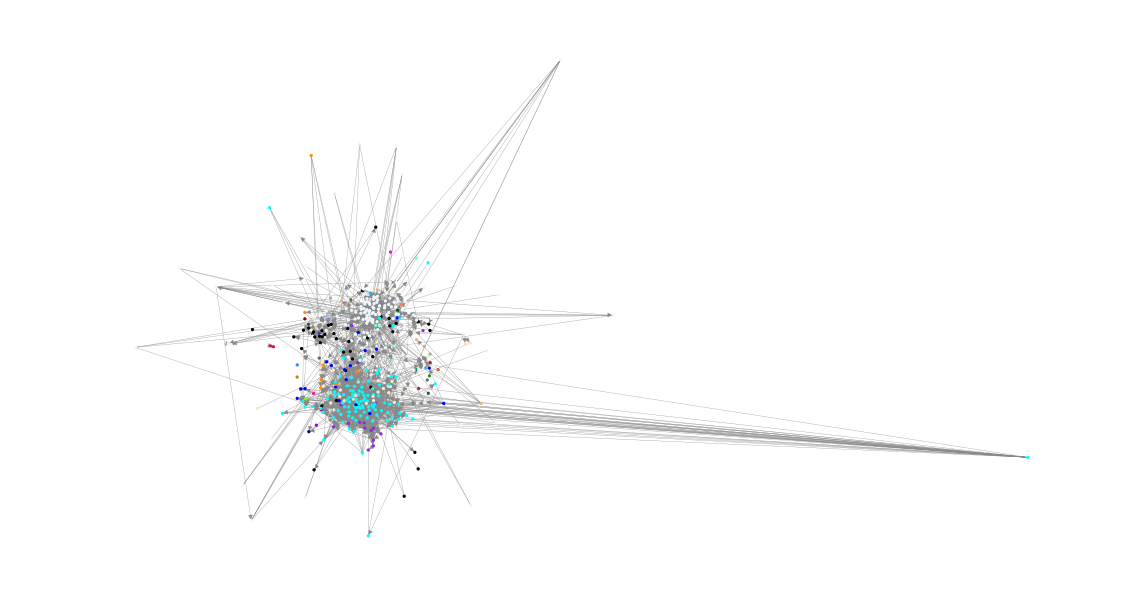

In [29]:
from matplotlib import colors as mcolors

plt.rcParams["figure.figsize"] = [15, 8];

#We create an array with the colors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
com_colors = []
for com in set(partition.values()):
    com_colors.append(list(mcolors.CSS4_COLORS)[com % len(list(mcolors.CSS4_COLORS)) ])


positions = forceatlas2.forceatlas2_networkx_layout(rt_graph,
                                                    pos=None,
                                                    iterations=6000)
      
node_colors = [com_colors[partition[node]] for node in rt_graph.nodes]

weights = {}
for u, v in rt_graph.edges:
    weights[(u, v)] = rt_graph[u][v]['weight']
    
nx.draw(rt_graph,
        positions,
        cmap=plt.get_cmap('jet'),
        node_size = 5,
        node_color = node_colors,
        edge_color = "#898989",
        overlap = False,
        width = .3,
        with_labels=False)
plt.show()

- Compare the communities found by your algorithm with the parties by creating a matrix $\mathbf{D}$ with dimension $(B \times C$, where $B$ is the number of parties and $C$ is the number of communities. We set entry $D(i,j)$ to be the number of nodes that party $i$ has in common with community $j$. The matrix $\mathbf{D}$ is what we call a confusion matrix.

In [30]:
parties = {(0, 'Republican'), (1, 'Democratic')}
communities = set(partition.values())

D = [[0 for j in range(len(communities))] for i in range(len(parties))]
for p, party in parties:
    for com in communities:
        nodes_ij = [n for n in rt_graph.nodes
                    if(rt_graph.node[n]['party'].item() == party
                       and partition[n] == com)]
        D[p][com] = len(nodes_ij)

- Plot the confusion matrix and explain how well the communities you've detected correspond to the parties. Consider the following questions:
    - Are there any republicans grouped with democrats (and vice versa)?
        - _There can be found some cases colored in a softer tone, although they are not as significant as communities of members from the same party._
- Does the community detection algorithm sub-divide the parties? Do you know anything about American politics that could explain such sub-divisions? Answer in your own words.
   - _It groups nodes by popularity (number of connections) regardless of the party they belong to. From our very little knowledge on American politics, there will be some communities populated by representatives that are independent (have more freedom to vote against their party, for instance). Their independance means their decisions make a smaller influence among others, therefore they will have less retweets._ 

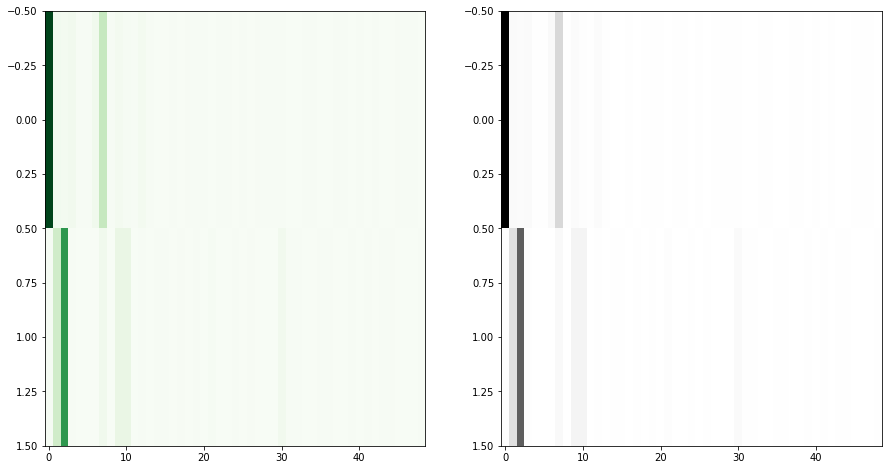

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

a = D

fig = plt.figure()
ax1 = fig.add_subplot(121)
# Bilinear interpolation - this will look blurry
ax1.imshow(a,
           interpolation='nearest',
           cmap=cm.Greens,
           aspect="auto")

ax2 = fig.add_subplot(122)
# 'nearest' interpolation - faithful but blocky
ax2.imshow(a,
           interpolation='nearest',
           cmap=cm.Greys,
           aspect="auto")
plt.show()

<hr>

# <u style="color:#7CA280"> Part 2: What do republican and democratic members tweet about? </u>

### <i style="color:#7CA280"> Exercise 4: TF-IDF of the republican and democratic tweets. </i>

We will create two documents, one containing the words extracted from tweets of republican members, and the other for Democratic members. We will then use TF-IDF to compare the content of these two documents and create a word-cloud. The procedure you should use is exactly the same you used in exercise 2 of week 7. The main steps are summarized below:
- Create two large documents, one for the democratic and one for the republican party. Tokenize the pages, and combine the tokens into one long list including all the pages of the members of the same party.
    - Exclude all twitter handles.
    - Exclude punctuation.
    - Exclude stop words (if you don't know what stop words are, go back and read NLPP1e again).
    - Exclude numbers (since they're difficult to interpret in the word cloud).
    - Set everything to lower case.
    - Compute the TF-IDF for each document.

In [1]:
import nltk
from nltk.corpus import stopwords

for acc in rt_graph.nodes:
    
    f = io.open(path+acc, 'r', encoding='utf-8').read()
    
    words = nltk.word_tokenize(f)

    words = [w for w in words
             if not re.search(r"(RT)((?:\b\W@(\w+))+)|@|RT|http|amp", w)] #remove Twitter handles
    words = [w.lower() for w in words]
    words = [w for w in words 
             if w not in stopwords.words('english')] # remove stop words
    words = [w for w in words
             if not re.search(r'[.,\/#!?$%\^&\*;:{}=\-\—_`´’~()\']', w)] # remove punctuations
    words = [w for w in words
             if not re.search(r'\s|\d+(\.\d+)?', w)] # remove digits
    
    #divide Republicans and Democrats
    if rt_graph.node[acc]['party'].item() == 'Republican':
        file = open("data/republicans.txt","w")
        file.write(" ".join(words))
    else:
        file = open("data/democrats.txt","w")
        file.write(" ".join(words))
    file.close()

NameError: name 'rt_graph' is not defined

- Now, create word-cloud for each party. Are these topics less "boring" than the wikipedia topics from a few weeks ago? Why? Comment on the results.
    - <i> This can be the result of different facts.
        
        First, unlike Wikipedia, content in Twitter is not intended to be neutral.
        
        Second, topics are more up-to-date thus Twitter is the main channel of communication used by politicians nowadays to keep the citizens informed. Wikipedia's words were related to general information of the members of the house, probably writen by a third person._
    
    As a reminder, the words that appeared using Wikipedia as our source were district, committee, senate, ...</i>

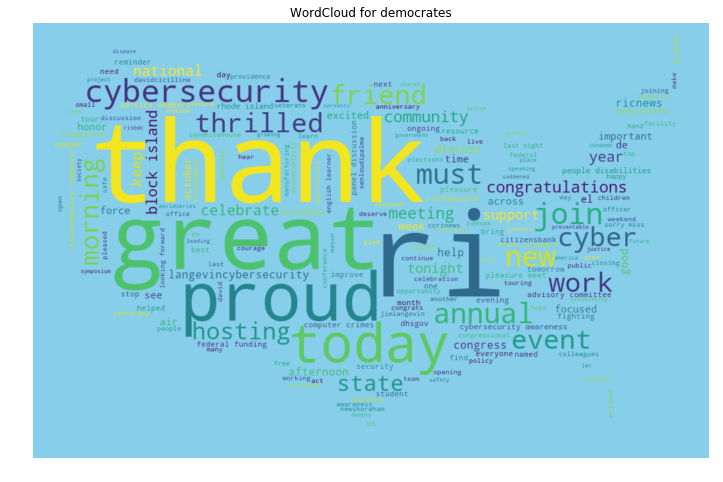

In [35]:
from wordcloud import WordCloud
import numpy as np
from PIL import Image
import requests

plt.rcParams["figure.figsize"] = [15, 8];

mask = np.array(Image.open(requests.get('http://imgur.com/9ezskNd.png', stream=True).raw))

dem = open("data/democrats.txt","r").read()
dem_words = nltk.word_tokenize(dem)
dem_text = nltk.Text(dem_words)

rep = open("data/republicans.txt","r").read()
rep_words = nltk.word_tokenize(rep)
rep_text = nltk.Text(rep_words)

def drawWordCloud(text):
    wordcloud = WordCloud(background_color="skyblue", mask=mask).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

drawWordCloud(dem)
plt.title("WordCloud for democrates");

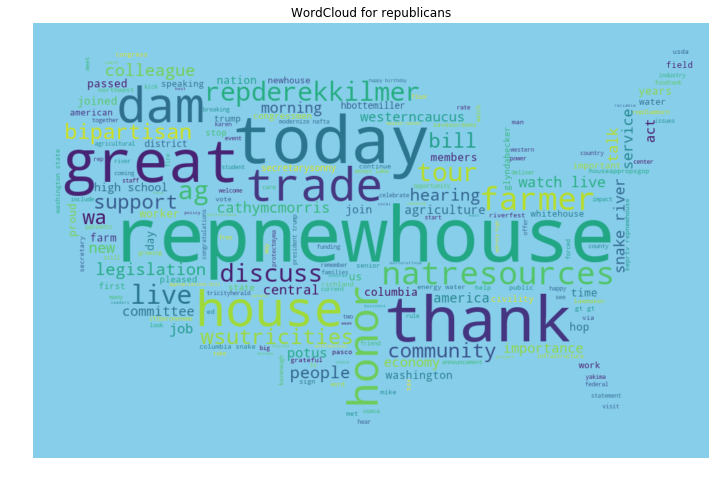

In [39]:
drawWordCloud(rep)
plt.title("WordCloud for republicans");

<hr>

# <u style="color:#7CA280"> Part 3: Sentiment analysis</u>

### <i style="color:#7CA280"> Exercise 5: Sentiment over the Twitter data. </i>

- Download the LabMT wordlist. It's available as supplementary material from Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter (Data Set S1). Describe briefly how the list was generated.
    - _The list was generated following by analysing words on a large number of Twitter users' feed, then conducting a survey of happinness evaluation of thousands of words._

In [4]:
import nltk
labMT = pd.read_csv('data/s001.txt', sep="\t")

- Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc).
    - _Our solution gives a tuple with the happiness average and the happiness standard deviation of the text (input as a list of tokens). The calculation is the average of each of the parameters, taking in account only the words that are inclueded in the labMT list of words._

In [5]:
def calculate_sentiment(content):
    words = {token: 0 for token in nltk.word_tokenize(content)}
    happiness_avg_total = 0.
    happiness_std_dev_total = 0.
    sent_words = 0.
    for token in words.keys():
        if token in list(labMT.word) :
            happiness_avg_total += float(labMT[labMT.word == token].happiness_average)
            happiness_std_dev_total += float(labMT[labMT.word == token].happiness_standard_deviation)
            sent_words += 1.
    happiness_avg = happiness_avg_total/sent_words if sent_words else 0
    happiness_std_dev = happiness_std_dev_total/sent_words if sent_words else 0
    return (happiness_avg, happiness_std_dev)

- Create two lists: one including the tweets written by democratic members, and the other including the tweets written by republican members (in the text files, tweets are separated by newlines).

In [17]:
#tweets_rep, tweets_dem = {}, {}
sentiment_rep, sentiment_dem = {}, {}
i = len(os.listdir(path))
for file in os.listdir(path):
    print(i)
    tweets = io.open(path+file, 'r', encoding='utf-8').read().split('\n')
    for tweet in tweets:
        #tokenized_tweet = nltk.word_tokenize(tweet)
        sentiment = calculate_sentiment(tweet)
        if not sentiment:
            continue
        if tw_parties[tw_parties.tw_name == file].Party.item() == 'Republican':
            sentiment_rep[tweet] = sentiment
        else:
            sentiment_dem[tweet] = sentiment
    i -= 1

420
419
418
417
416
415
414
413
412
411
410
409
408
407
406
405
404
403
402
401
400
399
398
397
396
395
394
393
392
391
390
389
388
387
386
385
384
383
382
381
380
379
378
377
376
375
374
373
372
371
370
369
368
367
366
365
364
363
362
361
360
359
358
357
356
355
354
353
352
351
350
349
348
347
346
345
344
343
342
341
340
339
338
337
336
335
334
333
332
331
330
329
328
327
326
325
324
323
322
321
320
319
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
303
302
301
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220
219
218
217
216
215
214
213
212
211
210
209
208
207
206
205
204
203
202
201
200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171


In [20]:
for tweet in sentiment_rep.keys():
    print(sentiment_rep[tweet])
    break

(5.190909090909091, 1.194227272727273)


- Calculate the sentiment of each tweet and plot the distribution of sentiment for each of the two lists. Are there significant differences between the two? Which party post more positive tweets?
    - _We update the value in the dictionary using a tuple with the happinness average and the standard deviation._

In [21]:
import numpy
import matplotlib.pyplot as plt

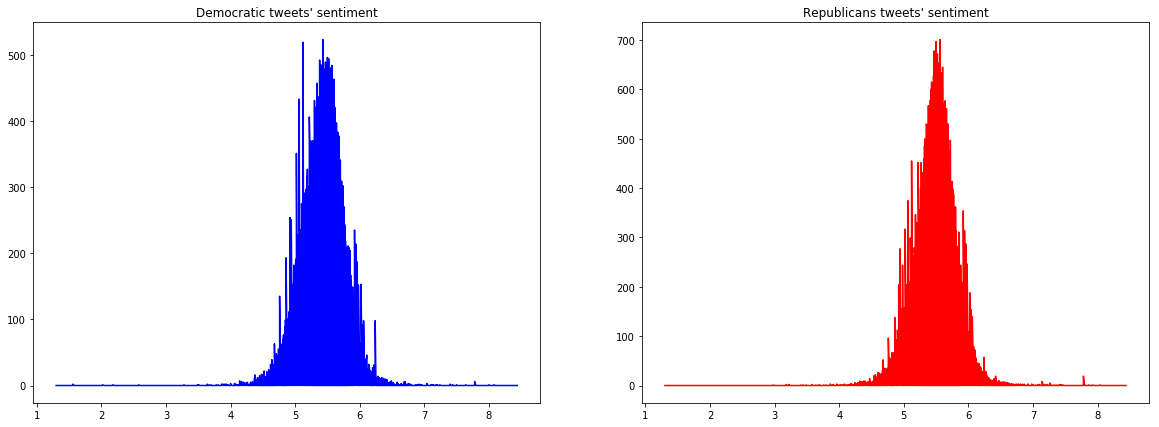

In [22]:
fig = plt.figure(figsize=(20, 7))

sub1 = fig.add_subplot(121)
sub1.plot(color='red')
sents_dem = [sent[0] for sent in sentiment_dem.values()]

binned_sentiment_dem = numpy.histogram(sents_dem, bins=sorted(labMT.happiness_average))

sub1.plot(binned_sentiment_dem[1][0:len(binned_sentiment_dem[0])], binned_sentiment_dem[0], color='blue')
plt.title("Democratic tweets\' sentiment")

sub2 = fig.add_subplot(122)
sents_rep = [sent[0] for sent in sentiment_rep.values()]
binned_sentiment_rep = numpy.histogram(sents_rep, bins=sorted(labMT.happiness_average))
sub2.plot(binned_sentiment_rep[1][0:len(binned_sentiment_rep[0])], binned_sentiment_rep[0], color='red')
plt.title("Republicans tweets\' sentiment")


plt.show()

- Compute the average m and standard deviation $\sigma$ of the tweets sentiment (considering tweets by both republican and democrats).

In [62]:
import numpy as np
all_tweets = dict(sentiment_rep, **sentiment_rep)
        
m = np.mean([elt[0] for elt in all_tweets.values() if elt != (0, 0)] )
std_dev = np.std([elt[0] for elt in all_tweets.values() if elt != (0, 0)])
positive_threshold = m + std_dev*2
negative_threshold = m - std_dev*2

print('m: ', m)
print('sigma: ', std_dev)
print('Negative threshold: ', negative_threshold)
print('Positive threshold: ', positive_threshold)

m:  5.485051408374587
sigma:  0.32541892335320877
Negative threshold:  4.83421356166817
Positive threshold:  6.135889255081004


_After running the following scripts we realized that our calculation of the standard deviation is biased because it considers all the words in the tweets, even the neutral (not in the sentiment list) ones. Including these words add a lot of zeros into the calculations deforming our parameters m and $\sigma$.  This explains why some of the words considered negative are actually positive (see the "WordCloud of negative words for republicans" below). _

- Now consider only tweets with sentiment lower than m-2$\sigma$. We will refer to them as negative tweets. Build a list containing the negative tweets written by democrats, and one for republicans. Compute the TF-IDF for these two lists (use the same pre-processing steps in Exercise 4). Create a word-cloud for each of them. Comment on the differences between the negative contents posted by republicans and democrats.

In [63]:
negative_dem = {tweet: 0 for tweet in sentiment_dem.keys()
                     if sentiment_dem[tweet][0] < (m - std_dev*2)}
negative_rep = {tweet: 0 for tweet in sentiment_rep.keys()
                     if sentiment_rep[tweet][0] < (m - std_dev*2)}

In [64]:
import nltk
from nltk.corpus import stopwords

negative_words_rep = []
for tweet in negative_rep.keys():
    words = nltk.word_tokenize(tweet)

    words = [w for w in words
             if not re.search(r"(RT)((?:\b\W@(\w+))+)|@|RT|http|amp", w)] #remove Twitter handles
    words = [w.lower() for w in words]
    words = [w for w in words 
             if w not in stopwords.words('english')] # remove stop words
    words = [w for w in words
             if not re.search(r'[.,\/#!?$%\^&\*;:{}=\-\—_`´’~()\']', w)] # remove punctuations
    words = [w for w in words
             if not re.search(r'\s|\d+(\.\d+)?', w)] # remove digits
    negative_words_rep.extend(words)

negative_words_dem = []
for tweet in negative_dem.keys():
    words = nltk.word_tokenize(tweet)

    words = [w for w in words
             if not re.search(r"(RT)((?:\b\W@(\w+))+)|@|RT|http|amp", w)] #remove Twitter handles
    words = [w.lower() for w in words]
    words = [w for w in words 
             if w not in stopwords.words('english')] # remove stop words
    words = [w for w in words
             if not re.search(r'[.,\/#!?$%\^&\*;:{}=\-\—_`´’~()\']', w)] # remove punctuations
    words = [w for w in words
             if not re.search(r'\s|\d+(\.\d+)?', w)] # remove digits
    negative_words_dem.extend(words)

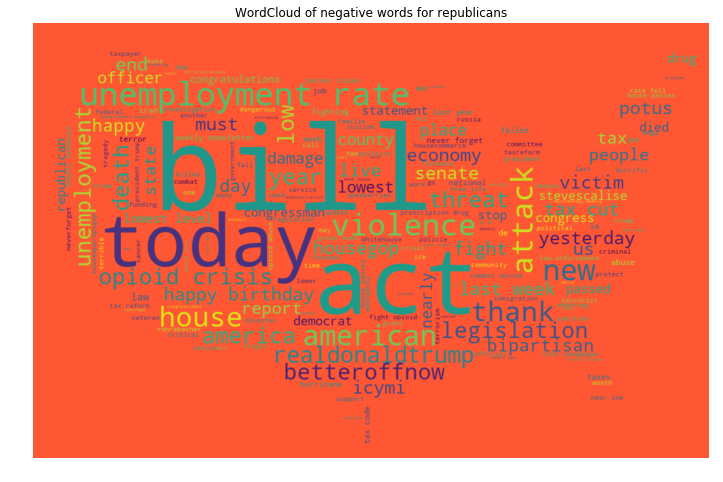

In [65]:
plt.rcParams["figure.figsize"] = [15, 8];

mask = np.array(Image.open(requests.get('http://imgur.com/9ezskNd.png', stream=True).raw))

def drawWordCloud(text):
    wordcloud = WordCloud(background_color="#FF5733", mask=mask).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

drawWordCloud(" ".join(negative_words_rep))
plt.title("WordCloud of negative words for republicans");

As mentionned before we had some issues in our calculations so the threshold suffered a divergence giving some 

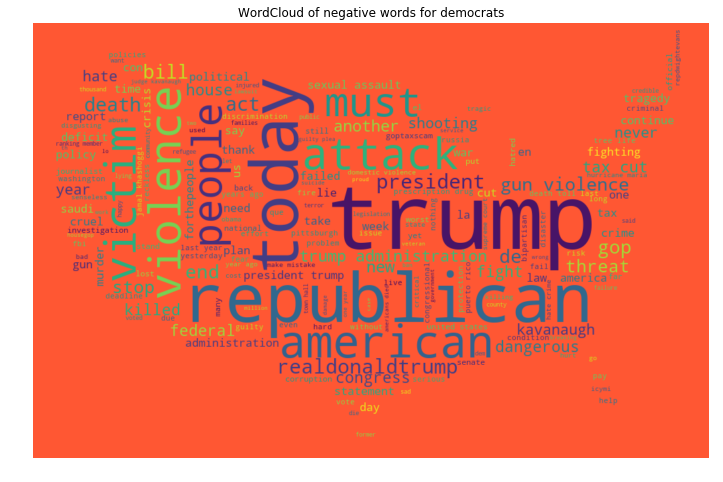

In [66]:
drawWordCloud(" ".join(negative_words_dem))
plt.title("WordCloud of negative words for democrats");

We can see that in the WordCloud that words address current issues like "attacks", "gun violence", "hate crime", "trump", ... which can be associated with the polemic decisions of the current president in foreign policies.

- Repeat the point above, but considering positive tweets instead (e.g. with sentiment larger than m+2$\sigma$). Comment on your results.

In [71]:
positive_dem = {tweet: 0 for tweet in sentiment_dem.keys()
                     if sentiment_dem[tweet][0] > (m + 2 * std_dev)}
positive_rep = {tweet: 0 for tweet in sentiment_rep.keys()
                     if sentiment_rep[tweet][0] > (m + 2 * std_dev)}

In [72]:
positive_words_rep = []
for tweet in positive_rep.keys():
    words = nltk.word_tokenize(tweet)

    words = [w for w in words
             if not re.search(r"(RT)((?:\b\W@(\w+))+)|@|RT|http|amp", w)] #remove Twitter handles
    words = [w.lower() for w in words]
    words = [w for w in words 
             if w not in stopwords.words('english')] # remove stop words
    words = [w for w in words
             if not re.search(r'[.,\/#!?$%\^&\*;:{}=\-\—_`´’~()\']', w)] # remove punctuations
    words = [w for w in words
             if not re.search(r'\s|\d+(\.\d+)?', w)] # remove digits
    positive_words_rep.extend(words)

positive_words_dem = []
for tweet in positive_dem.keys():
    words = nltk.word_tokenize(tweet)

    words = [w for w in words
             if not re.search(r"(RT)((?:\b\W@(\w+))+)|@|RT|http|amp", w)] #remove Twitter handles
    words = [w.lower() for w in words]
    words = [w for w in words 
             if w not in stopwords.words('english')] # remove stop words
    words = [w for w in words
             if not re.search(r'[.,\/#!?$%\^&\*;:{}=\-\—_`´’~()\']', w)] # remove punctuations
    words = [w for w in words
             if not re.search(r'\s|\d+(\.\d+)?', w)] # remove digits
    positive_words_dem.extend(words)

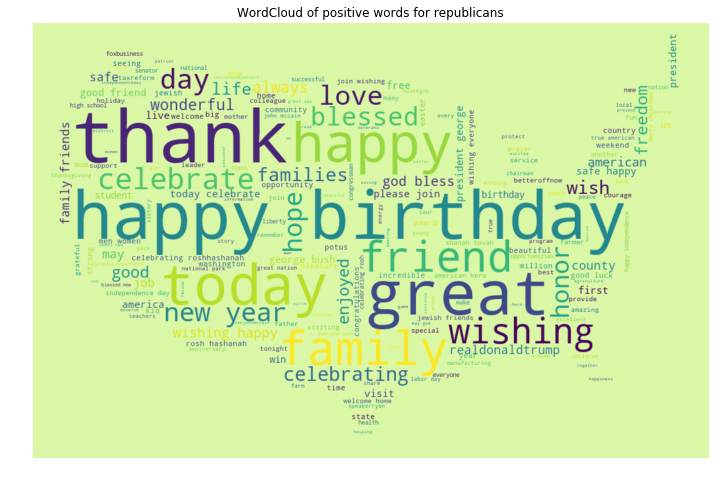

In [73]:
plt.rcParams["figure.figsize"] = [15, 8];

mask = np.array(Image.open(requests.get('http://imgur.com/9ezskNd.png', stream=True).raw))


#rep_text = nltk.Text(rep_words)

def drawWordCloud(text):
    wordcloud = WordCloud(background_color="#DAF7A6", mask=mask).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

drawWordCloud(" ".join(positive_words_rep))
plt.title("WordCloud of positive words for republicans");

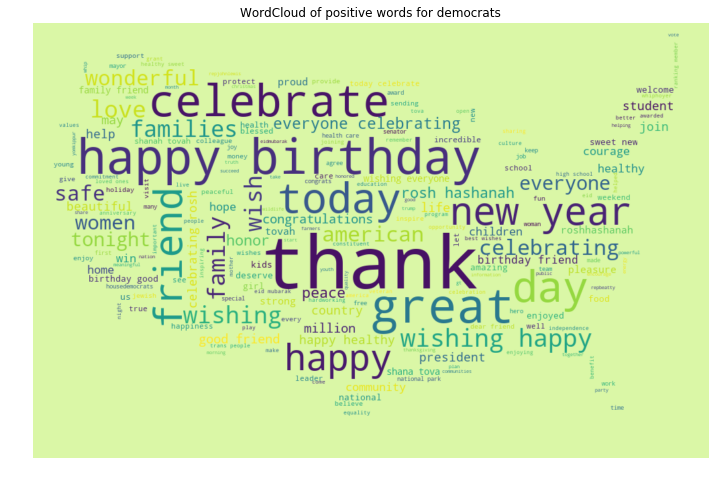

In [74]:
drawWordCloud(" ".join(positive_words_dem))
plt.title("WordCloud of positive words for democrats");

We can see the principles of each party in these WordClouds. For the republicans more conservative, patriotic values in messages that for example support the american troops such as ("welcome home", "us air force", ...) while the democrates show more progressive content supporting other matters like feminism, mentionning "girlscouts", "michelle obama", "alumna", ...

# MY VERSION PART 3

In [19]:
import pandas as pd
labMT = pd.read_csv('data/s001.txt', sep="\t")
print(labMT[labMT["word"] == "laughter"].happiness_average.values[0])

8.5


In [27]:
from nltk import word_tokenize

def computeSentiment(text):
    happiness_average, text = 0, word_tokenize(text)
    words = {word: text.count(word) for word in set(text)}
    
    for word in words:
        val_happiness = labMT[labMT["word"] == word].happiness_average.values
        if len(val_happiness)>0:
            happiness_average += float(val_happiness[0])
            
    return happiness_average / len(text)    

1.9959999999999998